In [1]:
import numpy as np
import tensorflow.compat.v1 as tf

from open_spiel.python import rl_environment
from open_spiel.python.pytorch import dqn as dqn_pt
from open_spiel.python.algorithms import dqn
from open_spiel.python.algorithms import random_agent

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def eval_against_random_bots(env, trained_agents, random_agents, num_episodes):
  """Evaluates `trained_agents` against `random_agents` for `num_episodes`."""
  num_players = len(trained_agents)
  sum_episode_rewards = np.zeros(num_players)
  for player_pos in range(num_players):
    cur_agents = random_agents[:]
    cur_agents[player_pos] = trained_agents[player_pos]
    for _ in range(num_episodes):
      time_step = env.reset()
      episode_rewards = 0
      while not time_step.last():
        player_id = time_step.observations["current_player"]
        if env.is_turn_based:
          agent_output = cur_agents[player_id].step(
              time_step, is_evaluation=True)
          action_list = [agent_output.action]
        else:
          agents_output = [
              agent.step(time_step, is_evaluation=True) for agent in cur_agents
          ]
          action_list = [agent_output.action for agent_output in agents_output]
        time_step = env.step(action_list)
        episode_rewards += time_step.rewards[player_pos]
      sum_episode_rewards[player_pos] += episode_rewards
  return sum_episode_rewards / num_episodes

In [3]:
def pt_main(game,
            config,
            checkpoint_dir,
            num_train_episodes,
            eval_every,
            hidden_layers_sizes,
            replay_buffer_capacity,
            batch_size):
  num_players = 2

  env = rl_environment.Environment(game, **config)
  info_state_size = env.observation_spec()["info_state"][0]
  num_actions = env.action_spec()["num_actions"]

  # random agents for evaluation
  random_agents = [
      random_agent.RandomAgent(player_id=idx, num_actions=num_actions)
      for idx in range(num_players)
  ]


  hidden_layers_sizes = [int(l) for l in hidden_layers_sizes]
  # pylint: disable=g-complex-comprehension
  agents = [
      dqn_pt.DQN(
          player_id=idx,
          state_representation_size=info_state_size,
          num_actions=num_actions,
          hidden_layers_sizes=hidden_layers_sizes,
          replay_buffer_capacity=replay_buffer_capacity,
          batch_size=batch_size) for idx in range(num_players)
  ]
  result = []
  for ep in range(num_train_episodes):
    if (ep + 1) % eval_every == 0:
      r_mean = eval_against_random_bots(env, agents, random_agents, 1000)
      result.append(r_mean)
      print("[%s] Mean episode rewards %s" %(ep + 1, r_mean))

    time_step = env.reset()
    while not time_step.last():
      player_id = time_step.observations["current_player"]
      if env.is_turn_based:
        agent_output = agents[player_id].step(time_step)
        action_list = [agent_output.action]
      else:
        agents_output = [agent.step(time_step) for agent in agents]
        action_list = [agent_output.action for agent_output in agents_output]
      time_step = env.step(action_list)

    # Episode is over, step all agents with final info state.
    for agent in agents:
      agent.step(time_step)
  return result

In [4]:
def tf_main(game,
            config,
            checkpoint_dir,
            num_train_episodes,
            eval_every,
            hidden_layers_sizes,
            replay_buffer_capacity,batch_size):
  num_players = 2

  env = rl_environment.Environment(game, **config)
  info_state_size = env.observation_spec()["info_state"][0]
  num_actions = env.action_spec()["num_actions"]

  # random agents for evaluation
  random_agents = [
      random_agent.RandomAgent(player_id=idx, num_actions=num_actions)
      for idx in range(num_players)
  ]

  with tf.Session() as sess:
    hidden_layers_sizes = [int(l) for l in hidden_layers_sizes]
    # pylint: disable=g-complex-comprehension
    agents = [
        dqn.DQN(
            session=sess,
            player_id=idx,
            state_representation_size=info_state_size,
            num_actions=num_actions,
            hidden_layers_sizes=hidden_layers_sizes,
            replay_buffer_capacity=replay_buffer_capacity,
            batch_size=batch_size) for idx in range(num_players)
    ]
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    
    result_tf = []
    for ep in range(num_train_episodes):
      if (ep + 1) % eval_every == 0:
        r_mean = eval_against_random_bots(env, agents, random_agents, 1000)
        result_tf.append(r_mean)
        print("[%s] Mean episode rewards %s" %(ep + 1, r_mean))

      time_step = env.reset()
      while not time_step.last():
        player_id = time_step.observations["current_player"]
        if env.is_turn_based:
          agent_output = agents[player_id].step(time_step)
          action_list = [agent_output.action]
        else:
          agents_output = [agent.step(time_step) for agent in agents]
          action_list = [agent_output.action for agent_output in agents_output]
        time_step = env.step(action_list)

      # Episode is over, step all agents with final info state.
      for agent in agents:
        agent.step(time_step)
  return result_tf

In [5]:
checkpoint_dir = "/tmp/dqn_test"
num_train_episodes = 10000
eval_every = 100

hidden_layers_sizes = [64, 64]
replay_buffer_capacity = int(1e5)
batch_size = 32

# BREAKTHROUGH

In [11]:
game = "breakthrough"
config = {"columns": 5, "rows": 5}

In [12]:
pt_result = pt_main(game,
                    config,
                    checkpoint_dir,
                    num_train_episodes,
                    eval_every,
                    hidden_layers_sizes,
                    replay_buffer_capacity,batch_size)

[100] Mean episode rewards [0.396 0.44 ]


/usr/local/lib/python3.8/dist-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


[200] Mean episode rewards [0.396 0.472]
[300] Mean episode rewards [0.522 0.49 ]
[400] Mean episode rewards [0.664 0.572]
[500] Mean episode rewards [0.676 0.578]
[600] Mean episode rewards [0.686 0.578]
[700] Mean episode rewards [0.72  0.484]
[800] Mean episode rewards [0.772 0.432]
[900] Mean episode rewards [0.664 0.384]
[1000] Mean episode rewards [0.616 0.332]
[1100] Mean episode rewards [0.646 0.338]
[1200] Mean episode rewards [0.586 0.348]
[1300] Mean episode rewards [0.512 0.328]
[1400] Mean episode rewards [0.474 0.324]
[1500] Mean episode rewards [0.416 0.316]
[1600] Mean episode rewards [0.548 0.266]
[1700] Mean episode rewards [0.64  0.174]
[1800] Mean episode rewards [0.622 0.226]
[1900] Mean episode rewards [0.524 0.3  ]
[2000] Mean episode rewards [0.568 0.132]
[2100] Mean episode rewards [0.544 0.14 ]
[2200] Mean episode rewards [0.698 0.06 ]
[2300] Mean episode rewards [0.696 0.188]
[2400] Mean episode rewards [0.726 0.346]
[2500] Mean episode rewards [0.792 0.404]


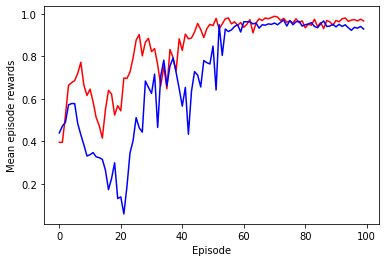

In [14]:
import matplotlib.pyplot as plt

ep = [x for x in range(len(pt_result))]
pt_r_mean0 = [y[0] for y in pt_result]
pt_r_mean1 = [y[1] for y in pt_result]

plt.plot(ep,pt_r_mean0, c='red')
plt.plot(ep,pt_r_mean1, c='blue')
plt.xlabel('Episode')
plt.ylabel('Mean episode rewards')
plt.show()

In [15]:
result_tf = tf_main(game,
                    config,
                    checkpoint_dir,
                    num_train_episodes,
                    eval_every,
                    hidden_layers_sizes,
                    replay_buffer_capacity,batch_size)

[100] Mean episode rewards [0.668 0.166]
[200] Mean episode rewards [0.582 0.026]
[300] Mean episode rewards [ 0.674 -0.1  ]
[400] Mean episode rewards [ 0.556 -0.128]
[500] Mean episode rewards [ 0.446 -0.142]
[600] Mean episode rewards [ 0.322 -0.142]
[700] Mean episode rewards [ 0.23  -0.214]
[800] Mean episode rewards [ 0.292 -0.236]
[900] Mean episode rewards [ 0.28  -0.298]
[1000] Mean episode rewards [ 0.224 -0.298]
[1100] Mean episode rewards [ 0.238 -0.306]
[1200] Mean episode rewards [ 0.224 -0.37 ]
[1300] Mean episode rewards [ 0.18  -0.404]
[1400] Mean episode rewards [ 0.24  -0.388]
[1500] Mean episode rewards [ 0.212 -0.36 ]
[1600] Mean episode rewards [ 0.29  -0.302]
[1700] Mean episode rewards [ 0.354 -0.37 ]
[1800] Mean episode rewards [ 0.524 -0.33 ]
[1900] Mean episode rewards [ 0.546 -0.242]
[2000] Mean episode rewards [ 0.65  -0.162]
[2100] Mean episode rewards [ 0.574 -0.158]
[2200] Mean episode rewards [ 0.512 -0.068]
[2300] Mean episode rewards [ 0.488 -0.204]
[

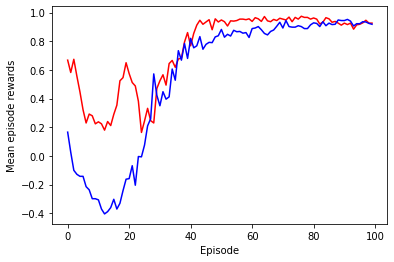

In [16]:
ep = [x for x in range(len(result_tf))]
tf_r_mean0 = [y[0] for y in result_tf]
tf_r_mean1 = [y[1] for y in result_tf]

plt.plot(ep,tf_r_mean0, c='red')
plt.plot(ep,tf_r_mean1, c='blue')
plt.xlabel('Episode')
plt.ylabel('Mean episode rewards')
plt.show()

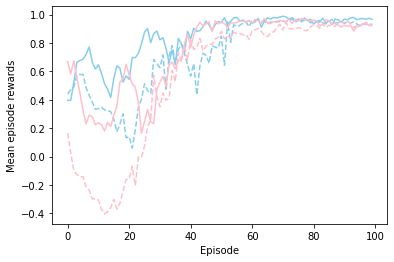

In [17]:
plt.plot(ep,pt_r_mean0, c='skyblue')
plt.plot(ep,pt_r_mean1, c='skyblue', linestyle='dashed')
plt.plot(ep,tf_r_mean0, c='pink')
plt.plot(ep,tf_r_mean1, c='pink', linestyle='dashed')
plt.xlabel('Episode')
plt.ylabel('Mean episode rewards')
plt.show()

# TIC-TAC-TOE

In [9]:
game = "tic_tac_toe"
config = {}
num_train_episodes = 20000
eval_every = 1000

In [10]:
pt_result = pt_main(game,
                    config,
                    checkpoint_dir,
                    num_train_episodes,
                    eval_every,
                    hidden_layers_sizes,
                    replay_buffer_capacity,batch_size)

[1000] Mean episode rewards [0.823 0.112]
[2000] Mean episode rewards [0.769 0.089]
[3000] Mean episode rewards [0.883 0.161]
[4000] Mean episode rewards [0.723 0.229]
[5000] Mean episode rewards [0.424 0.125]
[6000] Mean episode rewards [0.54  0.246]
[7000] Mean episode rewards [0.637 0.244]
[8000] Mean episode rewards [0.794 0.236]
[9000] Mean episode rewards [0.643 0.148]
[10000] Mean episode rewards [0.813 0.148]
[11000] Mean episode rewards [0.626 0.17 ]
[12000] Mean episode rewards [0.622 0.188]
[13000] Mean episode rewards [0.874 0.244]
[14000] Mean episode rewards [0.856 0.183]
[15000] Mean episode rewards [0.825 0.28 ]
[16000] Mean episode rewards [0.82  0.361]
[17000] Mean episode rewards [0.847 0.241]
[18000] Mean episode rewards [0.869 0.296]
[19000] Mean episode rewards [0.904 0.261]
[20000] Mean episode rewards [0.858 0.277]


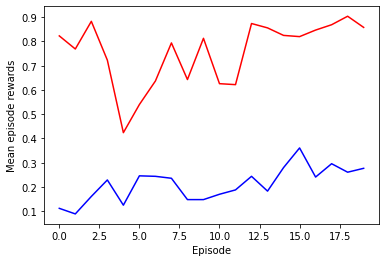

In [11]:
import matplotlib.pyplot as plt

ep = [x for x in range(len(pt_result))]
pt_r_mean0 = [y[0] for y in pt_result]
pt_r_mean1 = [y[1] for y in pt_result]

plt.plot(ep,pt_r_mean0, c='red')
plt.plot(ep,pt_r_mean1, c='blue')
plt.xlabel('Episode')
plt.ylabel('Mean episode rewards')
plt.show()

In [12]:
result_tf = tf_main(game,
                    config,
                    checkpoint_dir,
                    num_train_episodes,
                    eval_every,
                    hidden_layers_sizes,
                    replay_buffer_capacity,batch_size)

[1000] Mean episode rewards [ 0.493 -0.204]
[2000] Mean episode rewards [ 0.346 -0.244]
[3000] Mean episode rewards [ 0.537 -0.054]
[4000] Mean episode rewards [ 0.464 -0.059]
[5000] Mean episode rewards [0.46  0.144]
[6000] Mean episode rewards [0.442 0.08 ]
[7000] Mean episode rewards [0.606 0.068]
[8000] Mean episode rewards [0.447 0.165]
[9000] Mean episode rewards [0.702 0.196]
[10000] Mean episode rewards [0.694 0.227]
[11000] Mean episode rewards [0.757 0.213]
[12000] Mean episode rewards [0.829 0.149]
[13000] Mean episode rewards [0.733 0.186]
[14000] Mean episode rewards [0.8   0.318]
[15000] Mean episode rewards [0.849 0.308]
[16000] Mean episode rewards [0.789 0.198]
[17000] Mean episode rewards [0.825 0.353]
[18000] Mean episode rewards [0.804 0.367]
[19000] Mean episode rewards [0.827 0.355]
[20000] Mean episode rewards [0.796 0.368]


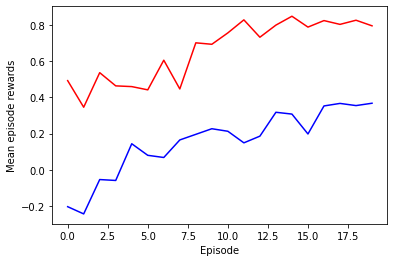

In [13]:
ep = [x for x in range(len(result_tf))]
tf_r_mean0 = [y[0] for y in result_tf]
tf_r_mean1 = [y[1] for y in result_tf]

plt.plot(ep,tf_r_mean0, c='red')
plt.plot(ep,tf_r_mean1, c='blue')
plt.xlabel('Episode')
plt.ylabel('Mean episode rewards')
plt.show()

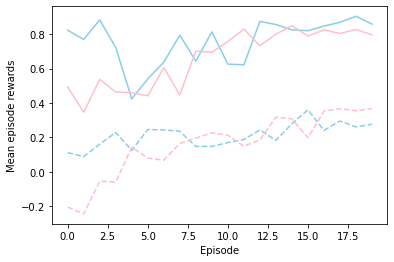

In [14]:
plt.plot(ep,pt_r_mean0, c='skyblue')
plt.plot(ep,pt_r_mean1, c='skyblue', linestyle='dashed')
plt.plot(ep,tf_r_mean0, c='pink')
plt.plot(ep,tf_r_mean1, c='pink', linestyle='dashed')
plt.xlabel('Episode')
plt.ylabel('Mean episode rewards')
plt.show()